### 1 - Imports and Initial Configurations

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Visualization settings for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

### 2 - Definition of the Simulated Environment (Pools, Rules, Costs, Weights)

In [2]:
# Defining the content pools and conditional rules for the "after" state
with open("../Ambient Data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

POOLS_BEFORE = enemies_and_events_data["pools"]
CONDITIONAL_RULES_BEFORE = enemies_and_events_data["conditional_rules"]

import copy
POOLS_AFTER = copy.deepcopy(POOLS_BEFORE)
#POOLS_AFTER['enemies']['Bedrose Gardener'] = {'cost': 10, 'weight': 65, 'tags': ['Common']}

CONDITIONAL_RULES_AFTER = copy.deepcopy(CONDITIONAL_RULES_BEFORE)
# New synergy rule for the added content
# CONDITIONAL_RULES_AFTER.append(
    
# )

### 3 - Implementation of the Content Generation Function

In [3]:
def draw_item(pool, current_budget, tag_context, rules):
    valid_items = []
    adjusted_weights = []

    for name, attributes in pool.items():
        if attributes['cost'] <= current_budget:
            final_weight = attributes['weight']
            # Apply conditional rules
            for rule in rules:
                if rule['if_tag'] in tag_context and rule['then_tag'] in attributes['tags']:
                    final_weight *= rule['multiplier']
            
            valid_items.append(name)
            adjusted_weights.append(final_weight)

    if not valid_items:
        # The original code had 'Nenhum' which was translated to 'None'.
        # This assumes a 'None' key exists in every pool as a fallback.
        return 'None', pool['None']

    # Normalize the weights to create a probability distribution
    weight_sum = sum(adjusted_weights)
    probabilities = [p / weight_sum for p in adjusted_weights]

    # Draw an item based on the adjusted weights
    choice = np.random.choice(valid_items, p=probabilities)
    return choice, pool[choice]


def generate_room_content(k, T, pools, rules):
    # Initial budget increases with depth k
    initial_budget = 10 + k * 2.5
    
    tag_context = set()
    result = {}

    # 1. Draw Enemy
    enemy_name, enemy = draw_item(pools['enemies'], initial_budget, tag_context, rules)
    result['enemy'] = enemy_name
    tag_context.update(enemy['tags'])
    remaining_budget_1 = initial_budget - enemy['cost']

    # 2. Draw Event
    event_name, event = draw_item(pools['events'], remaining_budget_1, tag_context, rules)
    result['event'] = event_name
    tag_context.update(event['tags'])
    remaining_budget_2 = remaining_budget_1 - event['cost']

    # 3. Draw Effect
    effect_name, effect = draw_item(pools['effects'], remaining_budget_2, tag_context, rules)
    result['effect'] = effect_name
    
    result['total_cost'] = (enemy['cost'] + event['cost'] + effect['cost'])
    return result

### 4 - Implementation of the Simulation Function

In [4]:
def run_simulation(pools, rules, n_simulations=10000):
    data = []
    for k_sim in range(1, 11):
        for _ in range(n_simulations // 10):
            room = generate_room_content(k=k_sim, T='standard', pools=pools, rules=rules)
            room['k'] = k_sim
            data.append(room)
    return pd.DataFrame(data)

### 5 - Simulation Before and After the New Addition

In [5]:
print("Starting simulations...")
df_before = run_simulation(POOLS_BEFORE, CONDITIONAL_RULES_BEFORE)
print("'BEFORE' simulation complete.")
df_after = run_simulation(POOLS_AFTER, CONDITIONAL_RULES_AFTER)
print("'AFTER' simulation complete.")

Starting simulations...
'BEFORE' simulation complete.
'AFTER' simulation complete.


### 6 - Analysis and Visualization Functions

In [6]:
def analyze_frequency(df_before, df_after, column):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    df_before[column].value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Frequency Distribution (BEFORE) - {column}')
    axes[0].set_ylabel('Relative Frequency')
    
    df_after[column].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title(f'Frequency Distribution (AFTER) - {column}')
    
    plt.suptitle(f'Frequency Analysis for Category: {column.upper()}', fontsize=16)
    plt.show()

def analyze_cost(df_before, df_after):
    plt.figure(figsize=(12, 7))
    sns.kdeplot(df_before['total_cost'], label='BEFORE', color='skyblue', fill=True)
    sns.kdeplot(df_after['total_cost'], label='AFTER', color='salmon', fill=True)
    plt.title('Distribution of Total Cost per Room (Difficulty)')
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def analyze_cooccurrence(df, title):
    cooc = pd.crosstab(df['enemy'], df['effect'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooc, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Enemy x Effect Co-occurrence Matrix ({title})')
    plt.show()

def calculate_info_metrics(df, col1, col2):
    # Marginal Entropy H(X)
    p_x = df[col1].value_counts(normalize=True)
    h_x = entropy(p_x, base=2)

    # Marginal Entropy H(Y)
    p_y = df[col2].value_counts(normalize=True)
    h_y = entropy(p_y, base=2)

    # Joint Entropy H(X, Y)
    p_xy = df.groupby([col1, col2]).size() / len(df)
    h_xy = entropy(p_xy, base=2)

    # Mutual Information I(X; Y) = H(X) + H(Y) - H(X,Y)
    i_xy = h_x + h_y - h_xy

    return {'H(col1)': h_x, 'H(col2)': h_y, 'H(col1,col2)': h_xy, 'I(col1;col2)': i_xy}


### 7 - Analysis of the Generator Function After the Addition

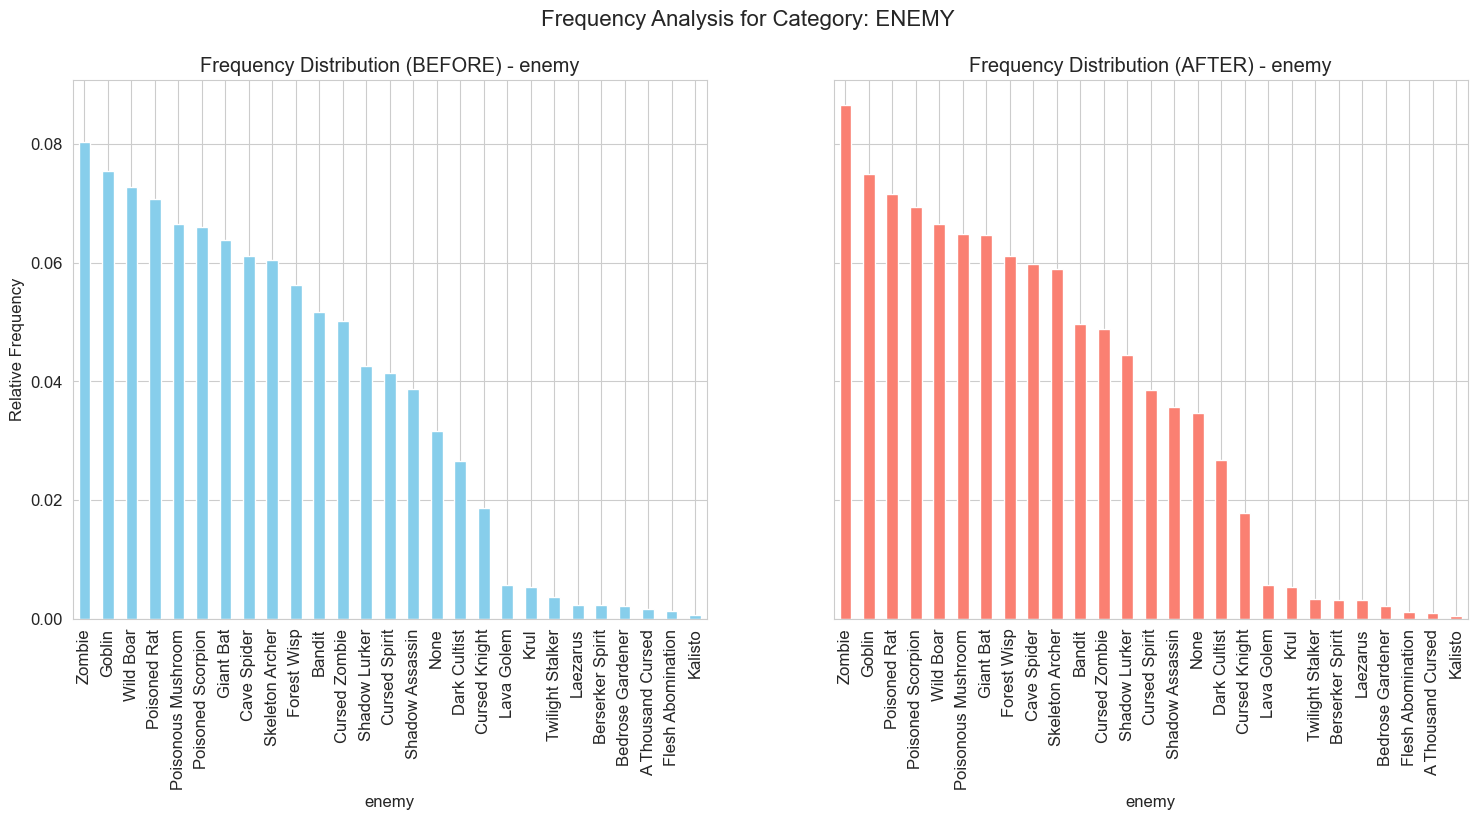

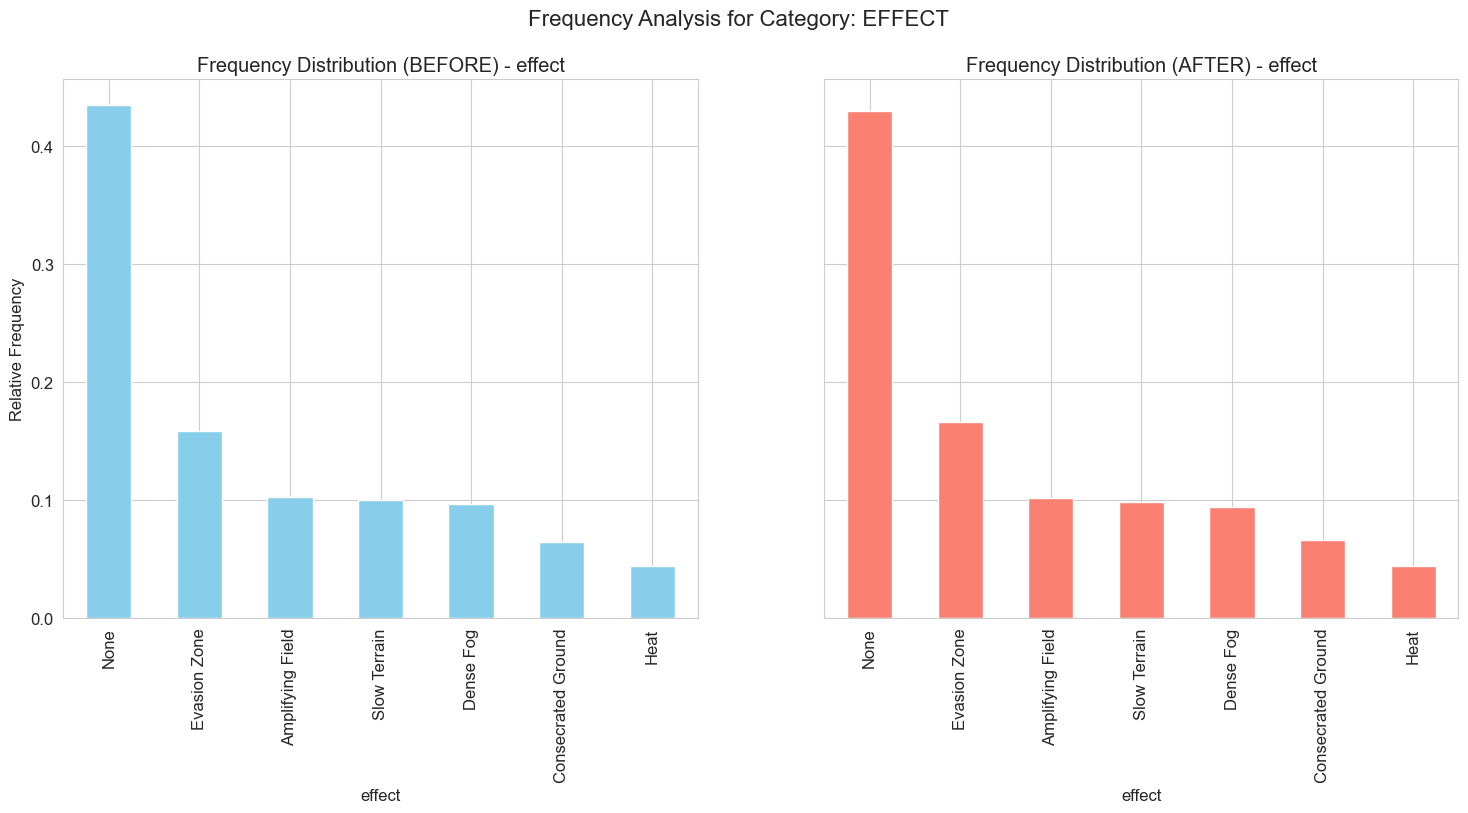

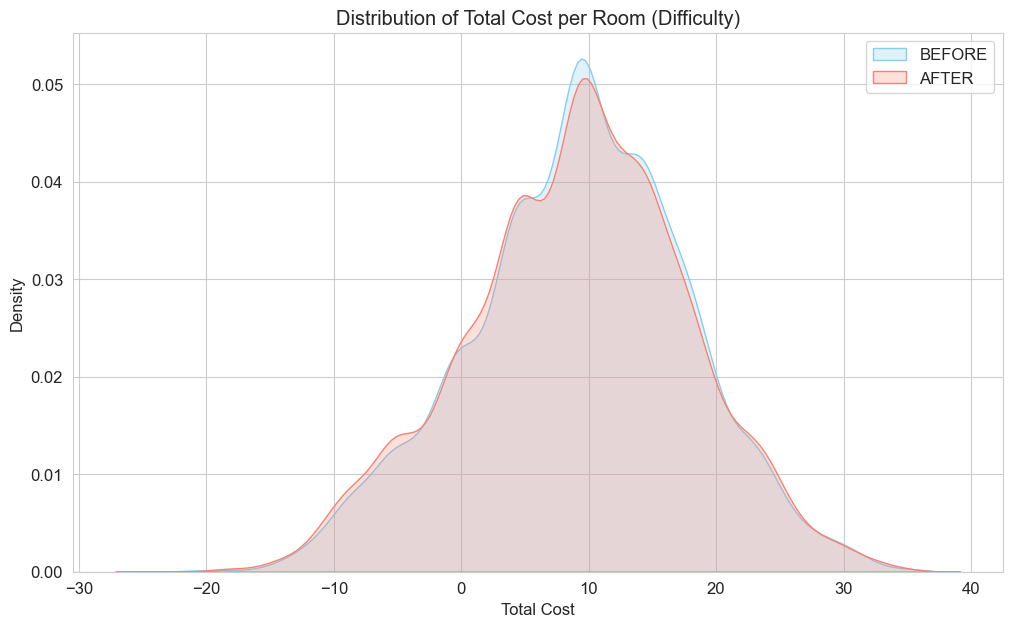

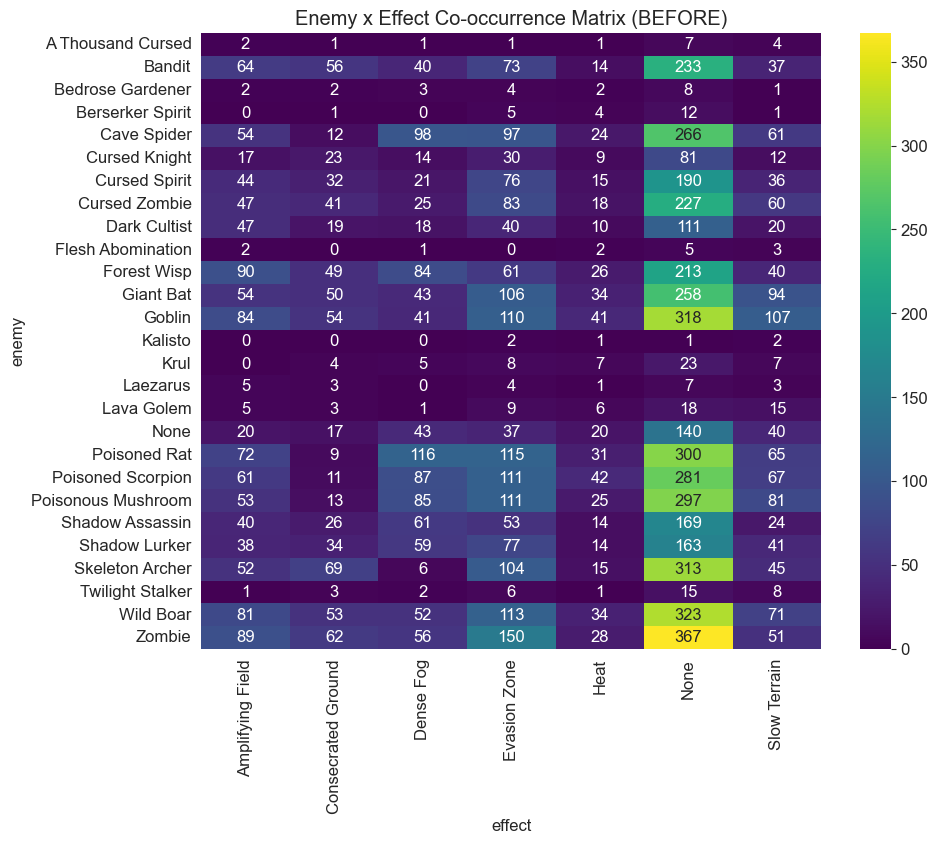

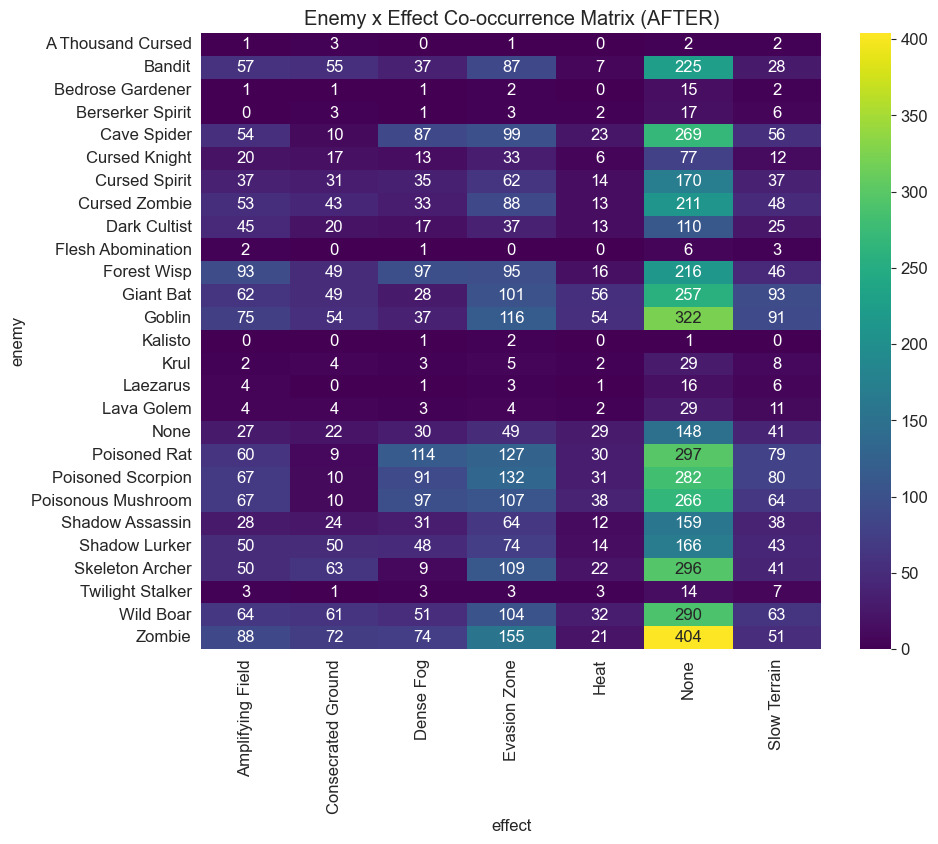



--- IMPACT CONTROL PANEL ---

                      Metric  Value BEFORE  Value AFTER  Change (%)
          Average Total Cost        9.2545       9.0697     -1.9969
          Entropy H(Enemies)        4.2296       4.2253     -0.1008
          Entropy H(Effects)        2.3904       2.3973      0.2871
Mutual Info I(Enemy; Effect)        0.0517       0.0513     -0.7141


In [7]:
# Frequency Analysis for Enemies and Effects
analyze_frequency(df_before, df_after, 'enemy')
analyze_frequency(df_before, df_after, 'effect')

# Total Cost Analysis
analyze_cost(df_before, df_after)

# Co-occurrence Analysis
analyze_cooccurrence(df_before, 'BEFORE')
analyze_cooccurrence(df_after, 'AFTER')

# Quantitative Summary Calculation and Presentation
metrics_before = calculate_info_metrics(df_before, 'enemy', 'effect')
metrics_after = calculate_info_metrics(df_after, 'enemy', 'effect')

summary = pd.DataFrame({
    'Metric': ['Average Total Cost', 'Entropy H(Enemies)', 'Entropy H(Effects)', 'Mutual Info I(Enemy; Effect)'],
    'Value BEFORE': [
        df_before['total_cost'].mean(),
        metrics_before['H(col1)'],
        metrics_before['H(col2)'],
        metrics_before['I(col1;col2)']
    ],
    'Value AFTER': [
        df_after['total_cost'].mean(),
        metrics_after['H(col1)'],
        metrics_after['H(col2)'],
        metrics_after['I(col1;col2)']
    ]
})

summary['Change (%)'] = ((summary['Value AFTER'] / summary['Value BEFORE']) - 1) * 100

print("\n\n--- IMPACT CONTROL PANEL ---\n")
print(summary.to_string(index=False, float_format="%.4f"))